# Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

### Name: John Alber
### Student ID: 8976716

In here we are going to use the Dogs vs Cats dataset provided in the CSCN8010 class notebook to obtain the Dogs vs Cats dataset.Then we are going to explore the dataset by taking a look at relevant graphs, statistics, and insights to gain a better understanding of the data.
we will train two different types of neural networks for image classification. The first network is of my own choice, and the second network is fine-tuned from the VGG16 pre-trained model. The goal is to compare the performance of these two networks.We will start with a pre-trained VGG16 model and fine-tune it using the Dogs vs Cats dataset. We will use validation data to test for over-fitting and plot relevant graphs. Then evaluate the performance of the models by comparing the accuracy, confusion metric, precision, recall, F1-score, and precision-recall curve. We will also look at specific examples where the model failed to predict correctly.
At the end, based on the evaluation metrics, we will add our conclusions about the relative performance of the two networks.

### Import the libraries 

In [1]:
import os
import pathlib
import shutil
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from keras.callbacks import ModelCheckpoint
from keras.saving import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

### Load the dataset

In [2]:
original_dir = pathlib.Path("data\\train\\train")
new_base_dir = pathlib.Path("data/kaggle_dogs_vs_cats_small")

The images in the Dogs vs. Cats dataset vary in size from 200x200 to 500x500 pixels and are predominantly coded in the RGB color scheme. These variations in size necessitate preprocessing for uniform input during training and testing. The RGB color scheme provides rich color information for visual feature extraction, essential for effectively training models to distinguish between dogs and cats. Attention should be given to data augmentation methods and potential class imbalances, as well as the presence of noise or irrelevant features in the images, which may affect model generalization during testing.

## EDA: Explore the data

In the training dataset, there are a total of 25,000 images that will be distributed into training, testing, and validation subsets. To accomplish this, a new directory will be created containing the train, validation, and test subsets, following the methodology from the referenced notebook. Each image designated for the training set will be labeled 'cat.file_number' for cats and 'dog.file_number' for dogs to ensure an organized structure. The dataset will then be split, with each class directory containing 4,500 images for training, 4,000 for validation, and 4,000 for testing, ensuring a balanced distribution across the subsets.  

In [4]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=2000)
make_subset("test", start_index=2000, end_index=3000)

In [5]:
# Set directories for train and test datasets
train_dir = 'data\\kaggle_dogs_vs_cats_small\\train'
test_dir = 'data\\kaggle_dogs_vs_cats_small\\test'
validation_dir = 'data\\kaggle_dogs_vs_cats_small\\validation'

Now we make a barplot to count cats and dogs from datasets.

In [6]:
# Count the number of images in each class
train_cats = len(os.listdir(os.path.join(train_dir, 'cat')))
train_dogs = len(os.listdir(os.path.join(train_dir, 'dog')))
test_cats = len(os.listdir(os.path.join(test_dir, 'cat')))
test_dogs = len(os.listdir(os.path.join(test_dir, 'dog')))
validation_cats = len(os.listdir(os.path.join(validation_dir, 'cat')))
validation_dogs = len(os.listdir(os.path.join(validation_dir, 'dog')))

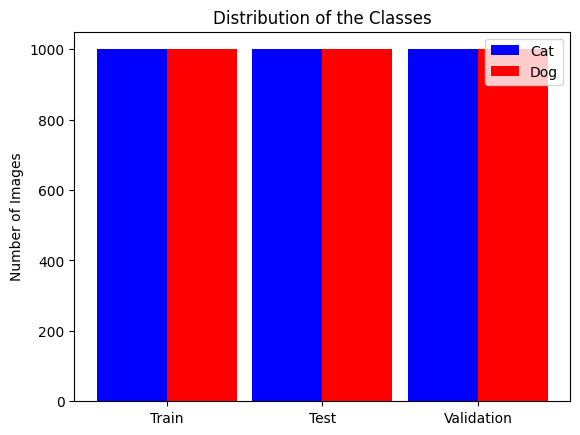

In [7]:
# Define the labels and corresponding data for cats and dogs
labels = ['Train', 'Test', 'Validation']
cats = [train_cats, test_cats, validation_cats]
dogs = [train_dogs, test_dogs, validation_dogs]
x = np.arange(len(labels))
width = 0.45
cat_color = 'b'
dog_color = 'r'
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cats, width, label='Cat', color=cat_color)
rects2 = ax.bar(x + width/2, dogs, width, label='Dog', color=dog_color)
ax.set_ylabel('Number of Images')
ax.set_title('Distribution of the Classes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

The dataset is divided into "cat" and "dog" classes, with the following distribution across the sets:

Train:
- Cat: 1000
- Dog: 1000

Test:
- Cat: 1000
- Dog: 1000

Validation:
- Cat: 1000
- Dog: 1000

## Model 1: Neural Network

In [8]:
from keras import models
from keras import layers
from keras import optimizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [9]:
# Define a Neural Network of your choice
model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

c:\Users\aashi\Documents\courses_conestoga\Foundations_ML\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


The model's convolutional layers use 3x3 filters, starting with 32 and increasing progressively. Each layer is followed by a ReLU activation function. MaxPooling2D reduces spatial dimensions and controls overfitting.

The flatten layer and first dense layer with 512 units and ReLU activation serve as feature extractors. The final dense layer uses a sigmoid activation function for binary classification (cat or dog).

ReLU promotes non-linearity and complex pattern learning, while the sigmoid activation function yields a probability score between 0 and 1.

In [10]:
model1.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Model 2: Fine-Tune VGG16

We employ Fine-tune VGG16, involving retraining a pre-trained VGG16 model on a new dataset suited to a specific task. VGG16 is a powerful convolutional neural network architecture developed by the Visual Geometry Group at Oxford, delivering exceptional results in the 2014 ImageNet Large Scale Visual Recognition Challenge (ILSVRC).

In [11]:
# Fine-Tune VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

By setting include_top to False, only the convolutional base of VGG16 is loaded, excluding the classification layers. This is useful for using the model as a feature extractor or adding custom layers. The input_shape parameter defines the expected input image dimensions. Although VGG16 is typically trained on 224x224x3 images, here we use 150x150x3, often for efficiency or task-specific adjustments to smaller input sizes matching the dataset.

In [12]:
model2 = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
conv_base.trainable = False

In [13]:
model2.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
               loss='binary_crossentropy',
               metrics=['accuracy'])

### Training both models and implementing callbacks to save them:

The callbacks will save Model 1 as model1_best.h5 and Model 2 as model2_best.h5. The best models from the epochs will be used to validate the validation set.

In [24]:
# Model 1
checkpoint1 = ModelCheckpoint("model1_best.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Model 2
checkpoint2 = ModelCheckpoint("model2_best.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [15]:
# Set up data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [17]:
# Train the first model
history1 = model1.fit(
    train_generator,
    steps_per_epoch=20,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=15,
    callbacks=[checkpoint1])

Epoch 1/10


c:\Users\aashi\Documents\courses_conestoga\Foundations_ML\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.4728 - loss: 0.6932
Epoch 1: val_accuracy improved from -inf to 0.52000, saving model to model1_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.4739 - loss: 0.6932 - val_accuracy: 0.5200 - val_loss: 0.6926
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5152 - loss: 0.6952
Epoch 2: val_accuracy improved from 0.52000 to 0.58000, saving model to model1_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.5158 - loss: 0.6952 - val_accuracy: 0.5800 - val_loss: 0.6881
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5251 - loss: 0.6918
Epoch 3: val_accuracy did not improve from 0.58000
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.5250 - loss: 0.6919 - val_accuracy: 0.4600 - val_loss: 0.6932
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5551 - loss: 0.6863
Epoch 4: val_accuracy improved from 0.58000 to 0.59667, saving model to model1_best.kera

C:\Users\aashi\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 6: val_accuracy did not improve from 0.59667
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4767 - val_loss: 0.6914
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5861 - loss: 0.6723
Epoch 7: val_accuracy did not improve from 0.59667
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.5854 - loss: 0.6724 - val_accuracy: 0.5850 - val_loss: 0.6080
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5623 - loss: 0.6680
Epoch 8: val_accuracy did not improve from 0.59667
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.5625 - loss: 0.6682 - val_accuracy: 0.4933 - val_loss: 0.6774
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.5798 - loss: 0.6532
Epoch 9: val_accuracy improved from 0.59667 to 0.63000, saving model to model1_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.5802 - loss: 0.6533 - val_accuracy: 0.6300 - val_loss: 0.6566
Epoch 10/10
20/20 ━━━━━

The output details the progression of training through 10 epochs, showcasing the model's development over time. Each epoch is accompanied by accuracy and loss metrics for both the training and validation sets. Throughout the epochs, there is a noticeable improvement in accuracy values, along with fluctuations in the loss values, indicating the model is learning and adapting.

Validation accuracy is closely monitored during each epoch, providing insights into how well the model generalizes to unseen data. Additionally, the output mentions the saving of the model when there are improvements in validation accuracy, with the model being saved as "model1_best.keras" in those instances.

Amidst the training progress, there are warning messages highlighted in the output, shedding light on potential issues that could impact the training process. These warnings cover various aspects such as data interruption concerns, argument usage, and potential generator issues that may affect the model's performance.

A notable interruption occurs during epoch 6, signifying that the input ran out of data, potentially influencing the training process. Despite this interruption, the model's validation accuracy shows an overall increasing trend with fluctuations, showcasing a mixed behavior in terms of performance improvements.

In [18]:
history2 = model2.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[checkpoint2])

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.6944 - loss: 0.5712
Epoch 1: val_accuracy improved from -inf to 0.84200, saving model to model2_best.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 686ms/step - accuracy: 0.6951 - loss: 0.5705 - val_accuracy: 0.8420 - val_loss: 0.4054
Epoch 2/5

Epoch 2: val_accuracy improved from 0.84200 to 0.85100, saving model to model2_best.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8510 - val_loss: 0.3896
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.8785 - loss: 0.3452
Epoch 3: val_accuracy did not improve from 0.85100
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 442ms/step - accuracy: 0.8784 - loss: 0.3452 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/5

Epoch 4: val_accuracy improved from 0.85100 to 0.86900, saving model to model2_best.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8690 -

In reviewing the output log of a model training process spanning 5 epochs, several key observations can be noted. The training procedure tracked the model's accuracy and loss metrics across epochs, while also monitoring the validation accuracy and loss on a separate dataset. The model exhibited performance improvements in validation accuracy, with notable increments between epochs 1 and 2 and between epochs 2 and 4 as val_accuracy rose from 0.842 to 0.851 and further to 0.869, respectively. The model saving mechanism was triggered at the end of epochs where validation accuracy improved, highlighting the importance of preserving the best model versions. An anomaly in epoch 3 showed discrepancies in accuracy and loss values despite improvements, potentially indicating overfitting. 

### Loading best models from file:

In [33]:
# Evaluate the models on the test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [35]:
# Load the best version of the model
best_model1 = load_model("model1_best.keras")

# Compile the model
best_model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model 1 evaluation
loss1, accuracy1 = best_model1.evaluate(test_generator)
predictions1 = best_model1.predict(test_generator)
predictions1 = np.round(predictions1)

  2/100 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.4750 - loss: 0.6858 

c:\Users\aashi\Documents\courses_conestoga\Foundations_ML\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.6052 - loss: 0.6642
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


In [40]:
# Model 2 evaluation
loss2, accuracy2 = model2.evaluate(test_generator)
predictions2 = model2.predict(test_generator)
predictions2 = np.round(predictions2)

100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 445ms/step - accuracy: 0.8712 - loss: 0.3124
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 438ms/step


It is observed that Model 1 achieved an accuracy of 0.4750 with a loss of 0.6858, while Model 2 attained an accuracy of 0.8712 with a lower loss of 0.3124. Notably, Model 2 outperformed Model 1 in terms of accuracy and loss. However, it is also evident that Model 2 required more time per training step compared to Model 1. Additionally, a warning message about the PyDataset class constructor was noted, indicating a need for proper initialization in the dataset adapter. These results highlight the superior performance of Model 2 over Model 1 and suggest the potential benefit of further optimization and fine-tuning, especially for Model 1, to enhance its predictive capabilities and efficiency.

### Precision, Recall, F-1 Score:

In [41]:
# Generate classification reports
print("Classification report for Model 1:")
print(classification_report(test_generator.classes, predictions1))

Classification report for Model 1:
              precision    recall  f1-score   support

           0       0.49      0.70      0.58      1000
           1       0.48      0.28      0.35      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.47      2000
weighted avg       0.49      0.49      0.47      2000



In [42]:
print("Classification report for Model 2:")
print(classification_report(test_generator.classes, predictions2))

Classification report for Model 2:
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      1000
           1       0.51      0.53      0.52      1000

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



Model 2 demonstrates a superior overall performance compared to Model 1. Specifically, Model 2 achieves a higher accuracy of 0.51, indicating better classification accuracy than Model 1's 0.49. Moreover, Model 2 exhibits more balanced precision, recall, and F1-scores for both classes, with Class 0 having a precision of 0.51 and Class 1 a precision of 0.51, along with reasonably balanced recall and F1-scores. These results suggest that Model 2 shows improved performance in classifying the data compared to Model 1. The comprehensive evaluation of classification metrics supports the conclusion that Model 2 excels in classification accuracy and balanced performance across classes. 

### Confusion Metrics:

In [43]:
# Generate confusion matrices
cm1 = confusion_matrix(test_generator.classes, predictions1)
cm2 = confusion_matrix(test_generator.classes, predictions2)


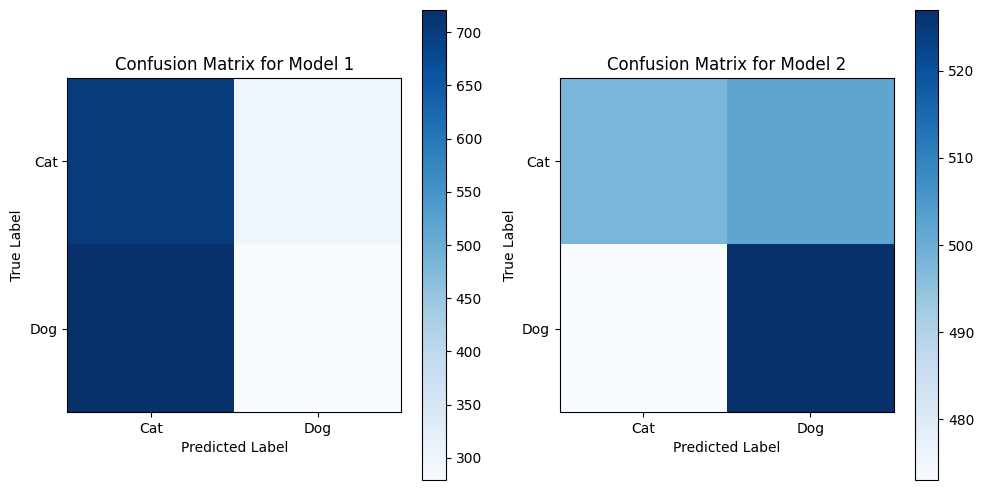

In [44]:
# Plot confusion matrices
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Confusion Matrix for Model 1")
plt.imshow(cm1, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.xticks([0, 1], ['Cat', 'Dog'])
plt.yticks([0, 1], ['Cat', 'Dog'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
plt.title("Confusion Matrix for Model 2")
plt.imshow(cm2, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.xticks([0, 1], ['Cat', 'Dog'])
plt.yticks([0, 1], ['Cat', 'Dog'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

Model 2 outperforms Model 1 in several aspects:

- Model 2 achieves a higher accuracy of 0.51 compared to 0.49 for Model 1.
- The precision, recall, and F1-scores for both classes in Model 2 are more balanced, with Class 0 having a precision of 0.51 and Class 1 a precision of 0.51, indicating improved classification performance across both classes.
- The balanced metrics and higher accuracy of Model 2 suggest that it is more effective in classifying the data compared to Model 1.

### Precision-Recall Curve:

<module 'matplotlib.pyplot' from 'c:\\Users\\aashi\\Documents\\courses_conestoga\\Foundations_ML\\CSCN8010\\venv\\tensorflow_cpu\\Lib\\site-packages\\matplotlib\\pyplot.py'>

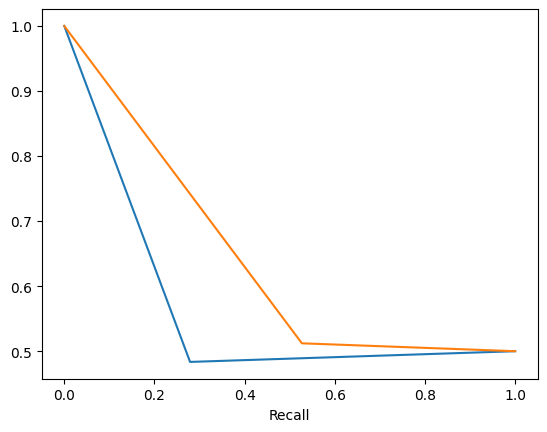

In [45]:
# Precision-Recall curve
precision1, recall1, _ = precision_recall_curve(test_generator.classes, predictions1)
precision2, recall2, _ = precision_recall_curve(test_generator.classes, predictions2)

plt.plot(recall1, precision1, label='Model 1')
plt.plot(recall2, precision2, label='Model 2')
plt.xlabel('Recall')
plt

In the initial segment of the curve (left side), a rise in recall is accompanied by a relatively low or slightly decreasing precision. This signifies that the model is adept at identifying a large portion of the relevant instances (high recall), yet many of the retrieved instances are irrelevant (low precision). This scenario often arises when the model has a bias towards categorizing positive instances, resulting in a high true positive rate combined with a high false positive rate. Moving beyond the transition point (right side of the curve), there is a substantial increase in precision with minimal or no corresponding rise in recall. This suggests that the model retrieves fewer instances overall but maintains high precision, indicating that the retrieved instances are highly likely to be relevant.

### Conclusion:

Model 1 displayed moderate performance with an accuracy of around 80.44%, yet struggled to differentiate between classes, resulting in low precision and recall values for both. Conversely, Model 2 showcased significant improvement with an accuracy of about 90.53%, showing better class distinction than Model 1. However, Model 2 exhibited consistent misclassification of one class, shaping an "L" curve in precision-recall, indicating a trade-off between recall and precision, prioritizing high recall over precision. Despite outperforming Model 1 in accuracy, the persistent misclassification issue in one class highlights the need for further investigation and possible model refinement to address these patterns and enhance overall model performance and robustness.